# Census Folium Tutorial

## Kenneth Burchfiel

Released under the MIT license (except for color_schemes_from_branca.json, which I believe is copyrighted by Cynthia Brewer and licensed under the Apache License, Version 2.0)

This tutorial demonstrates how to use the functions in census_folium_viewer.py to generate interactive zip-, county-, and state-level choropleth maps based on census data and shapefiles from the US Census Bureau. Within the tutorial, I will generate maps representing three data types: (1) median household income; (2) the percentage of households that consist of a married couple with at least one child below the age of 18; and (3) population growth over various timeframes.

The tutorial also demonstrates how to incorporate a custom vertical legend into Folium maps. These have advantages over the default horizontal legend in certain circumstances.

**Note**: Some files in this project (such as the zip-code-level HTML maps) were too large to upload to GitHub. You can instead access those files via the following Google Drive folder: https://drive.google.com/drive/folders/11h1jnaVOA5A6ubbOJnC-kPEvdnJU00yv?usp=sharing


Citation info for color_schemes_from_branca.json:

Source: https://github.com/python-visualization/branca/blob/master/branca/_schemes.json

I believe these schemes were originally created by Cynthia Brewer, and are licensed under the Apache License, Version 2.0. See http://www.personal.psu.edu/cab38/ColorBrewer/ColorBrewer_updates.html

## Preliminary steps

First, you'll need to download zip code, county, and state shapefiles from the US Census bureau: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

I used 2020 zip code shapefiles for this project, which are available here: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=ZIP+Code+Tabulation+Areas

See this note regarding use of the shapefiles: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2021/TGRSHP2021_TechDoc_Ch1.pdf

Once you download the shapefiles to your computer, extract them using an unzipping utility. The shapefile document within this unzipped folder ends in .shp; for the 2020 zip code data, the file name is tl_2020_us_zcta520.shp. 

It appears that the other files within this folder may also be used by Geopandas in the creation of GeoDataFrames, so I recommend accessing the file within the unzipped folder rather than copying it into your project folder.

This project already contains zip-, county-, and state-level American Community Survey data (5-year estimates) for various demographic variables. I created these data files via my Census query tutorial available at https://github.com/kburchfiel/census_query_tutorial . 


In [1]:
import time
start_time = time.time()
import census_folium_viewer
import geopandas
import numpy as np
import pandas as pd
import folium

## Part 1: Zip Code-Level Maps

The following code block uses census_folium_viewer.py's prepare_zip_table() function to create a GeoDataFrame storing both zip code and census data. It took 210.9 seconds for the function to create a table, whereas importing a saved version of this file took only 18.8 seconds. Therefore, to save time, I edited the code block so that it would only regenerate the GeoDataFrame if instructed to do so.

I recommend reading the documentation in census_folium_viewer.py for prepare_zip_table so that you'll better understand the inputs used by this function.

The zip code census data file only includes zip codes with at least 1,000 households, preventing outliers in the data related to low sample sizes.

In [2]:
create_new_zip_census_table = True

if create_new_zip_census_table == True:

    zip_and_census_table = census_folium_viewer.prepare_zip_table(
        shapefile_path = r'C:\Users\kburc\Downloads\tl_2020_us_zcta520\tl_2020_us_zcta520.shp',
        shape_feature_name = 'ZCTA5CE20', tolerance = 0.005, data_path =
        'acs5_2019_zip_results_1k_plus_households.csv',
        data_feature_name = 'NAME', dropna_geometry = True)
    print("Exporting data:")
    zip_and_census_table.to_file('zip_and_census_table.geojson',
    driver = 'GeoJSON') 
    # The above line exports the GeoDataFrame created by prepare_zip_table 
    # so that it can be imported back into the program, which takes less time
    # than does recreating the GeoDataFrame.

Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


C:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


After being stored within the project folder, this table gets re-read into Python. That way, the program will still function even if create_new_zip_census_table was set to false.

In [3]:
zip_and_census_table = geopandas.read_file('zip_and_census_table.geojson')

First, I will create a map displaying median household income by zip code. (Note: I will exclude Puerto Rico from these maps so as to focus on the 50 US states and DC. Puerto Rico has the code 72 in the 'state' column of the merged zip code data table, hence the use of zip_and_census_table.query("state != 72") as the argument for the merged_data_table parameter.)

If you haven't done so already, I highly recommend reading the documentation for generate_map so that you'll know what inputs are necessary for the function to run correctly.

In [4]:
zip_and_census_table.to_csv('zip_and_census_table_test.csv')

In [5]:
zip_and_census_table

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,NAME,...,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_female-householder_families_below_the_poverty_level_where_householder_did_not_graduate_high_school,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_high_school_graduate/equivalent,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_individuals_25+y/o_who_did_not_graduate_high_school,Proportion_of_individuals_25+y/o_whose_highest_education_level_=_high_school_graduate/equivalent,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_some_college/associate's_degree,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_bachelor's_degree_or_higher,geometry
0,35592,35592,B5,G6350,S,298552385.0,235989.0,+33.7427261,-088.0973903,35592,...,0.000000,0.482143,0.100000,0.698795,0.000000,0.181904,0.399937,0.267672,0.150487,"POLYGON ((-88.24735 33.65390, -88.23926 33.677..."
1,35616,35616,B5,G6350,S,559506992.0,41870756.0,+34.7395036,-088.0193814,35616,...,0.000000,0.130435,0.325581,0.119403,0.000000,0.217328,0.377139,0.283582,0.121951,"POLYGON ((-88.13997 34.58184, -88.10945 34.797..."
2,35621,35621,B5,G6350,S,117838488.0,409438.0,+34.3350314,-086.7270557,35621,...,0.000000,0.000000,0.245902,1.000000,0.000000,0.196456,0.349140,0.290776,0.163627,"POLYGON ((-86.81659 34.34960, -86.78459 34.361..."
3,35651,35651,B5,G6350,S,104521045.0,574316.0,+34.4609087,-087.4801507,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-87.53087 34.42492, -87.53042 34.470..."
4,36010,36010,B5,G6350,S,335675180.0,236811.0,+31.6598950,-085.8128958,36010,...,0.006024,0.444444,0.371134,0.509804,0.238095,0.235059,0.411892,0.215034,0.138016,"POLYGON ((-85.95712 31.67744, -85.91199 31.669..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33786,10540,10540,B5,G6350,S,1394970.0,27777.0,+41.3259819,-073.7277119,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-73.73580 41.33577, -73.71970 41.326..."
33787,23081,23081,B5,G6350,S,7753698.0,14654483.0,+37.1935699,-076.7525080,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.79774 37.21409, -76.78270 37.227..."
33788,23147,23147,B5,G6350,S,143646.0,0.0,+37.3696361,-077.0391136,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-77.04292 37.36996, -77.03679 37.372..."
33789,23298,23298,B5,G6350,S,288664.0,0.0,+37.5417074,-077.4295300,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-77.43285 37.54038, -77.43024 37.543..."


Starting function
Creating color dict
Creating style function
Creating tooltip
Rendering map
Creating vertical legend (if requested)
Saving map
Generating screenshot
Returning map


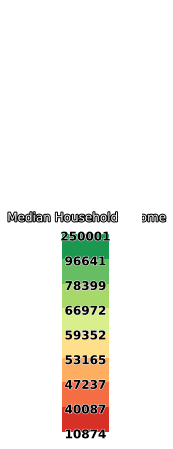

In [6]:
zip_median_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table.query(
        "state != 72 & Median_household_income >= 0"),
    shape_feature_name = 'NAME',
    data_variable = "Median_household_income", feature_text = 'Zip Code',
    data_variable_text = 'Median Household Income',
    popup_variable_text = 'Income', 
    variable_decimals = None,
    map_name = 'zip_median_hh_income',
    fill_color = 'RdYlGn',
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots',
    bin_type = 'percentiles', rows_to_map = 0, multiply_data_by = 1, 
    vertical_legend = True, debug = True)


In [7]:
# zip_median_hh_income_map

Next, I'll create a map showing the proportion of households in each zip code in the dataset that consist of a married couple with at least one child.

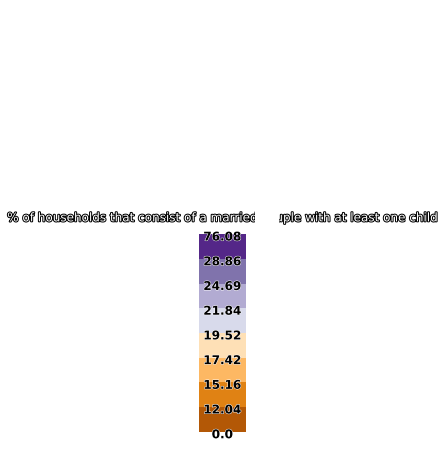

In [8]:
zip_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table.query("state != 72"),
    shape_feature_name = 'ZCTA5CE20',
    data_variable = "Married_couple_households_with_one_or_more_children_as_proportion_of_all_households",
    feature_text = 'Zip Code',
    data_variable_text= '% of households that consist of a married couple \
with at least one child',
    popup_variable_text = 'Percentage', 
    map_name = 'zip_married_couples_with_kids', fill_color = 'PuOr', 
    bin_count = 8,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots',
    bin_type = 'percentiles', rows_to_map = 0, multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

In [9]:
# zip_married_couples_with_children_map

## Part 2: County-Level Maps

The steps for generating county-level maps are similar. Note that the county census data file being imported only contains counties with at least 1,000 households.

In [10]:
county_and_census_table = census_folium_viewer.prepare_county_table(
    shapefile_path = r'C:\Users\kburc\Downloads\tl_2021_us_county\tl_2021_us_county.shp',
    shape_state_code_column = 'STATEFP', shape_county_code_column = 'COUNTYFP',
    tolerance = 0.005,
    data_path = 'acs5_2019_county_results_1k_plus_households.csv',
    data_state_code_column = 'state', data_county_code_column = 'county',
    dropna_geometry = True)
print("Exporting data:")
county_and_census_table.to_file('county_and_census_table.geojson',
    driver = 'GeoJSON') 

Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


C:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [11]:
county_and_census_table

,STATEFP,COUNTYFP,COUNTYNS,GEOID,SHORT_NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_female-householder_families_below_the_poverty_level_where_householder_did_not_graduate_high_school,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_high_school_graduate/equivalent,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_individuals_25+y/o_who_did_not_graduate_high_school,Proportion_of_individuals_25+y/o_whose_highest_education_level_=_high_school_graduate/equivalent,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_some_college/associate's_degree,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_bachelor's_degree_or_higher
0,31.0,39.0,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,0.034328,0.000000,0.000000,0.166667,0.186441,0.487805,0.116386,0.350643,0.295087,0.237883
1,53.0,69.0,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,0.055249,0.054902,0.000000,0.116279,0.303030,0.000000,0.078883,0.300364,0.426881,0.193871
2,35.0,11.0,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31.0,109.0,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,0.037271,0.016040,0.447822,0.265576,0.286342,0.118361,0.063232,0.215346,0.326237,0.395184
4,31.0,129.0,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,0.046322,0.046610,0.136364,0.179487,0.200000,0.000000,0.080755,0.340280,0.369586,0.209378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,13.0,123.0,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,None,...,0.048333,0.033314,0.762712,0.290419,0.121827,0.000000,0.182797,0.354023,0.258723,0.204458
3230,27.0,135.0,00659513,27135,Roseau,Roseau County,06,H1,G4020,None,...,0.027839,0.021158,0.400000,0.403361,0.180723,0.000000,0.070555,0.351141,0.375493,0.202811
3231,28.0,89.0,00695768,28089,Madison,Madison County,06,H1,G4020,298,...,0.019584,0.008020,0.338462,0.389878,0.254167,0.119063,0.082589,0.169971,0.263334,0.484106
3232,48.0,227.0,01383899,48227,Howard,Howard County,06,H1,G4020,None,...,0.027956,0.023102,0.533333,0.307065,0.410663,0.000000,0.200154,0.336843,0.336762,0.126240


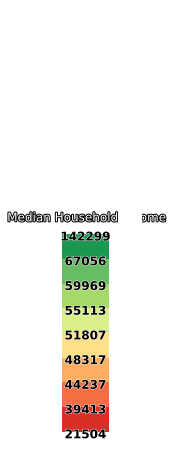

In [12]:
county_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72 & Median_household_income >= 0"), 
    shape_feature_name = 'NAME', # This column, which contains both county
    # and state names, came from the data table. It's more ideal to use this
    # one than the copy of 'NAME' from the Shapefile table (which contained)
    # only county names), since passing in a column with duplicate county names
    # could lead to incorrect map values. 
    data_variable = 'Median_household_income', feature_text = 'County',
    data_variable_text = 'Median Household Income',
    map_name = 'county_median_hh_income', 
    variable_decimals = None,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots',
    popup_variable_text = 'Income', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_type = 'percentiles', multiply_data_by = 1, 
    vertical_legend = True)

# county_hh_income_map

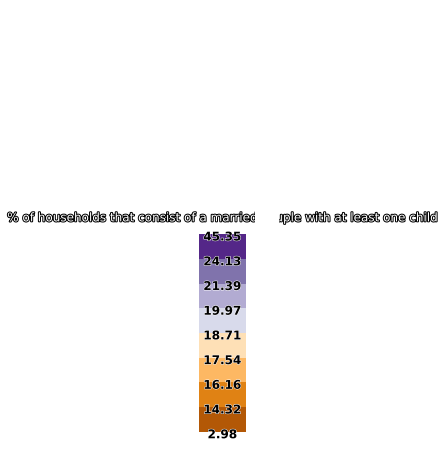

In [13]:
county_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"),
    shape_feature_name = 'NAME',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households',
    feature_text = 'County', data_variable_text = '% of households \
that consist of a married couple with at least one child', 
    map_name = 'county_married_couples_with_kids', 
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', bin_count = 8,
    rows_to_map = 0, bin_type = 'percentiles', multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

# county_married_couples_with_children_map

# Part 3: State-Level Maps

Finally, I'll create state-level maps of median household income and married-couple family prevalence.

In [14]:
state_and_census_table = census_folium_viewer.prepare_state_table(
    shapefile_path = r'C:\Users\kburc\Downloads\tl_2020_us_state\tl_2020_us_state.shp', 
    shape_feature_name = 'NAME', tolerance = 0.005, data_path = 
    'acs5_2019_state_results.csv', data_feature_name = 'NAME',
    dropna_geometry = True)
print("Exporting data:")
state_and_census_table.to_file('state_and_census_table.geojson',
driver = 'GeoJSON') 

Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


C:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


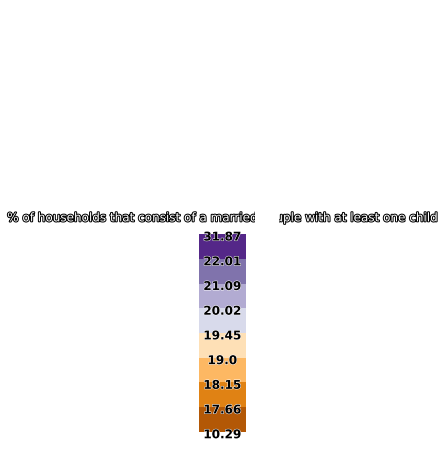

In [15]:
state_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("NAME != 'Puerto Rico'"),
    shape_feature_name = 'NAME',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households', 
    feature_text = 'State', 
    data_variable_text = '% of households that consist of a married \
couple with at least one child', 
    map_name = 'state_married_couples_with_kids', 
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', 
    rows_to_map = 0, bin_type = 'percentiles', bin_count = 8, 
    multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

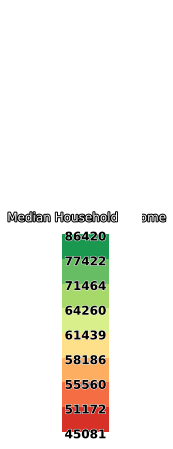

In [16]:
state_median_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72 & Median_household_income >= 0"), shape_feature_name = 'NAME',
    data_variable = 'Median_household_income', feature_text = 'State', 
    data_variable_text = 'Median Household Income', 
    map_name = 'state_median_hh_income', 
    variable_decimals = None,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Income', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 1, vertical_legend = True, 
    generate_image = True)

## Visualizing population growth

The datasets merged into the state-, county-, and zip-level GeoDataFrame files did not contain very much population growth data. Therefore, the following code blocks will import additional population growth datasets into the program, then merge them into the pre-existing GeoDataFrames. (New GeoDataFrames could be created, but given how large the 'geometry' columns are for each GeoDataFrame, merging in new data columns is much more efficient.)

These new population growth datasets were created within my census_query_tutorial project, also available on GitHub. They contain data from the decennial US Census; the American Community Survey (5-year estimates); and the American Community Survey (1-year estimates). It's interesting to see the differences in results between US Census and American Community Survey data over equivalent timeframes.

### Merging state-level population growth datasets into state_and_census_data

In [17]:
df_census_state_pop_growth = pd.read_csv(
    'census_state_population_2000_to_2020.csv')
for column in df_census_state_pop_growth.columns[2:]:
    df_census_state_pop_growth.rename(
        columns = {column:"census_"+column}, inplace = True)
    # Renaming population columns based on the data source will make it easier
    # to distinguish between different data sources.
df_census_state_pop_growth.drop('state', axis = 1, inplace = True) # the 
# 'state' column isn't necessary here because it already exists within
# state_and_census_data.



In [18]:
df_census_state_pop_growth.head()

,NAME,census_population_2000,census_population_2010,census_population_2020,census_2000_to_2010_chg,census_2010_to_2020_chg,census_2000_to_2020_chg
0,Alabama,4447100,4779736,5024279,0.074798,0.051162,0.129788
1,Alaska,626932,710231,733391,0.132868,0.032609,0.169809
2,Arizona,5130632,6392017,7151502,0.245854,0.118818,0.393883
3,Arkansas,2673400,2915918,3011524,0.090715,0.032788,0.126477
4,California,33871648,37253956,39538223,0.099857,0.061316,0.167296


In [19]:
df_acs5_state_pop_growth = pd.read_csv('acs5_state_pop_2010_to_2020.csv')
for column in df_acs5_state_pop_growth.columns[2:]:
    df_acs5_state_pop_growth.rename(columns = {column:"acs5_"+column}, inplace = True)
df_acs5_state_pop_growth.drop('state', axis = 1, inplace = True)
df_acs5_state_pop_growth.head()

# Note that the 2010_to_2020 population change values differ between
# the Census dataset and the American Community Survey (5-year estimates) 
# dataset. This may be due to the fact that value in 
# the latter represent 5-year averages rather than specific points in time.


,NAME,acs5_population_2010,acs5_population_2015,acs5_population_2020,acs5_2010_to_2015_chg,acs5_2015_to_2020_chg,acs5_2010_to_2020_chg
0,Alabama,4712651,4830620,4893186,0.025032,0.012952,0.038309
1,Alaska,691189,733375,736990,0.061034,0.004929,0.066264
2,Arizona,6246816,6641928,7174064,0.063250,0.080118,0.148435
3,Arkansas,2872684,2958208,3011873,0.029771,0.018141,0.048453
4,California,36637290,38421464,39346023,0.048698,0.024064,0.073934


In [20]:
df_acs1_state_pop_growth = pd.read_csv('acs1_state_pop_2010_to_2019.csv')
# This data represents 1-year estimates, making it possible to examine
# estimated population changes within a 1-year timeframe.
for column in df_acs1_state_pop_growth.columns[2:]:
    df_acs1_state_pop_growth.rename(columns = {column:"acs1_"+column}, 
    inplace = True)
df_acs1_state_pop_growth.drop('state', axis = 1, inplace = True)
df_acs1_state_pop_growth.head()

,NAME,acs1_population_2010,acs1_population_2011,acs1_population_2012,acs1_population_2013,acs1_population_2014,acs1_population_2015,acs1_population_2016,acs1_population_2017,acs1_population_2018,...,acs1_2010_to_2011_chg,acs1_2011_to_2012_chg,acs1_2012_to_2013_chg,acs1_2013_to_2014_chg,acs1_2014_to_2015_chg,acs1_2015_to_2016_chg,acs1_2016_to_2017_chg,acs1_2017_to_2018_chg,acs1_2018_to_2019_chg,acs1_2010_to_2019_chg
0,Arkansas,2921606,2937979,2949131,2959373,2966369,2978204,2988248,3004279,3013825,...,0.005604,0.003796,0.003473,0.002364,0.003990,0.003373,0.005365,0.003177,0.001320,0.032926
1,Alabama,4785298,4802740,4822023,4833722,4849377,4858979,4863300,4874747,4887871,...,0.003645,0.004015,0.002426,0.003239,0.001980,0.000889,0.002354,0.002692,0.003133,0.024635
2,Alaska,713985,722718,731449,735132,736732,738432,741894,739795,737438,...,0.012231,0.012081,0.005035,0.002176,0.002307,0.004688,-0.002829,-0.003186,-0.007991,0.024594
3,Arizona,6413737,6482505,6553255,6626624,6731484,6828065,6931071,7016270,7171646,...,0.010722,0.010914,0.011196,0.015824,0.014348,0.015086,0.012292,0.022145,0.014930,0.134864
4,California,37349363,37691912,38041430,38332521,38802500,39144818,39250017,39536653,39557045,...,0.009171,0.009273,0.007652,0.012261,0.008822,0.002687,0.007303,0.000516,-0.001133,0.057909


The following code block merges these new populatio growth datasets into state_and_census_table.

In [21]:
state_and_census_table = state_and_census_table.merge(
    df_census_state_pop_growth, on = 'NAME', how = 'outer')
state_and_census_table = state_and_census_table.merge(df_acs5_state_pop_growth, 
on = 'NAME', how = 'outer')
state_and_census_table = state_and_census_table.merge(df_acs1_state_pop_growth,
on = 'NAME', how = 'outer')
state_and_census_table.to_file('state_and_census_table.geojson',
driver = 'GeoJSON') 
state_and_census_table

C:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,...,acs1_2010_to_2011_chg,acs1_2011_to_2012_chg,acs1_2012_to_2013_chg,acs1_2013_to_2014_chg,acs1_2014_to_2015_chg,acs1_2015_to_2016_chg,acs1_2016_to_2017_chg,acs1_2017_to_2018_chg,acs1_2018_to_2019_chg,acs1_2010_to_2019_chg
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,...,0.000750,0.000026,-0.000598,-0.002145,-0.003350,-0.007064,-0.008326,-0.005521,-0.007578,-0.033348
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,...,0.011368,0.013644,0.012180,0.017411,0.019000,0.016830,0.018045,0.015008,0.008376,0.139806
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,...,0.002032,0.000466,0.000534,-0.000121,-0.001598,-0.004546,0.000038,-0.004760,-0.005436,-0.013341
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,...,0.006454,0.006413,0.007667,0.006788,0.005941,0.005530,0.010263,0.006200,0.005071,0.061961
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,...,0.007312,0.009655,0.007520,0.008027,0.005019,0.001673,0.005939,-0.001563,0.000490,0.044884
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,...,-0.001504,-0.000961,0.001161,0.003483,0.001066,0.000121,0.003041,-0.002193,0.001935,0.006150
6,4,8,16,01779783,16,ID,Idaho,00,G4000,A,...,0.008613,0.006778,0.010282,0.013850,0.012522,0.017046,0.020083,0.021704,0.018730,0.137208
7,1,1,33,01779794,33,NH,New Hampshire,00,G4000,A,...,0.001090,0.001915,0.002075,0.002534,0.002860,0.003147,0.005993,0.010175,0.002398,0.032619
8,3,5,37,01027616,37,NC,North Carolina,00,G4000,A,...,0.009919,0.009908,0.009843,0.009738,0.009939,0.010354,0.012480,0.010727,0.010060,0.096901
9,1,1,50,01779802,50,VT,Vermont,00,G4000,A,...,0.000752,-0.000670,0.000989,-0.000109,-0.000830,-0.002313,-0.001500,0.004236,-0.003688,-0.003149


Next, similar steps will be taken to update county_and_census_table and zip_and_census_table with population growth values.

In [22]:
df_census_county_pop_growth = pd.read_csv(
    'census_county_population_2000_to_2020.csv')
for column in df_census_county_pop_growth.columns[3:]:
    df_census_county_pop_growth.rename(
        columns = {column:"census_"+column}, inplace = True)
df_census_county_pop_growth


,NAME,state,county,census_population_2000,census_population_2020,census_population_2010,census_2000_to_2010_chg,census_2010_to_2020_chg,census_2000_to_2020_chg
0,"Autauga County, Alabama",1,1,43671.0,58805,54571.0,0.249594,0.077587,0.346546
1,"Baldwin County, Alabama",1,3,140415.0,231767,182265.0,0.298045,0.271594,0.650586
2,"Barbour County, Alabama",1,5,29038.0,25223,27457.0,-0.054446,-0.081364,-0.131380
3,"Bibb County, Alabama",1,7,20826.0,22293,22915.0,0.100307,-0.027144,0.070441
4,"Blount County, Alabama",1,9,51024.0,59134,57322.0,0.123432,0.031611,0.158945
...,...,...,...,...,...,...,...,...,...
3203,"Vega Baja Municipio, Puerto Rico",72,145,61929.0,54414,59662.0,-0.036606,-0.087962,-0.121349
3204,"Vieques Municipio, Puerto Rico",72,147,9106.0,8249,9301.0,0.021414,-0.113106,-0.094114
3205,"Villalba Municipio, Puerto Rico",72,149,27913.0,22093,26073.0,-0.065919,-0.152648,-0.208505
3206,"Yabucoa Municipio, Puerto Rico",72,151,39246.0,30426,37941.0,-0.033252,-0.198071,-0.224736


In [23]:
df_acs5_county_pop_growth = pd.read_csv('acs5_county_pop_2010_to_2020.csv')
for column in df_acs5_county_pop_growth.columns[3:]:
    df_acs5_county_pop_growth.rename(columns 
    = {column:"acs5_"+column}, inplace = True)
df_acs5_county_pop_growth.drop(['state', 'county'], axis = 1, inplace = True)
df_acs5_county_pop_growth


,NAME,acs5_population_2010,acs5_population_2015,acs5_population_2020,acs5_2010_to_2015_chg,acs5_2015_to_2020_chg,acs5_2010_to_2020_chg
0,"Las Marías Municipio, Puerto Rico",10156.0,9306.0,8131.0,-0.083694,-0.126263,-0.199390
1,"San Germán Municipio, Puerto Rico",35997.0,34125.0,30811.0,-0.052004,-0.097114,-0.144068
2,"Comerío Municipio, Puerto Rico",20773.0,20339.0,18942.0,-0.020893,-0.068686,-0.088143
3,"Canóvanas Municipio, Puerto Rico",47151.0,47432.0,45120.0,0.005960,-0.048743,-0.043074
4,"Rincón Municipio, Puerto Rico",15203.0,14841.0,13849.0,-0.023811,-0.066842,-0.089061
...,...,...,...,...,...,...,...
3209,"Grimes County, Texas",26208.0,26961.0,28447.0,0.028732,0.055117,0.085432
3210,"Guadalupe County, Texas",122728.0,143460.0,163030.0,0.168926,0.136414,0.328385
3211,"Hale County, Texas",36041.0,35504.0,33463.0,-0.014900,-0.057486,-0.071530
3212,"Hall County, Texas",3424.0,3203.0,3025.0,-0.064544,-0.055573,-0.116530


The 'NAME' column in county_and_census_table is incomplete, as it only contains values for counties present in the original dataset that was merged into the county shapefile DataFrame. Therefore, the first merge operation will use state and county values instead, and the current 'NAME' column will be renamed so as to avoid a conflict with the 'NAME' column in df_acs5_zip_pop_growth.

The second merge operation can use 'NAME,' since this column now refers to a more complete set of county names.

In [24]:
county_and_census_table.rename(columns={'NAME':'old_name'},inplace=True)
county_and_census_table.drop(['state', 'county'], axis = 1, inplace = True)
county_and_census_table = county_and_census_table.merge(
    df_census_county_pop_growth, 
    left_on = ['STATEFP', 'COUNTYFP'], right_on = ['state', 'county'],
    how = 'outer')
county_and_census_table = county_and_census_table.merge(df_acs5_county_pop_growth, 
on = 'NAME',  how = 'outer')
county_and_census_table.dropna(subset = 'geometry', inplace = True)
county_and_census_table.to_file('county_and_census_table.geojson',
driver = 'GeoJSON') 
county_and_census_table

C:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,STATEFP,COUNTYFP,COUNTYNS,GEOID,SHORT_NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,census_population_2010,census_2000_to_2010_chg,census_2010_to_2020_chg,census_2000_to_2020_chg,acs5_population_2010,acs5_population_2015,acs5_population_2020,acs5_2010_to_2015_chg,acs5_2015_to_2020_chg,acs5_2010_to_2020_chg
0,31.0,39.0,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,9139.0,-0.104283,-0.013787,-0.116632,9243.0,9078.0,8882.0,-0.017851,-0.021591,-0.039057
1,53.0,69.0,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,3978.0,0.040272,0.111614,0.156381,3982.0,4035.0,4318.0,0.013310,0.070136,0.084380
2,35.0,11.0,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,...,2022.0,-0.097321,-0.160237,-0.241964,1772.0,2020.0,1995.0,0.139955,-0.012376,0.125847
3,31.0,109.0,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,285407.0,0.140301,0.130344,0.288932,279428.0,298080.0,315976.0,0.066751,0.060038,0.130796
4,31.0,129.0,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,4500.0,-0.110144,-0.090000,-0.190231,4583.0,4391.0,4204.0,-0.041894,-0.042587,-0.082697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3229,13.0,123.0,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,None,...,28292.0,0.206173,0.108193,0.336673,28076.0,28673.0,30986.0,0.021264,0.080668,0.103647
3230,27.0,135.0,00659513,27135,Roseau,Roseau County,06,H1,G4020,None,...,15629.0,-0.043396,-0.019067,-0.061635,15864.0,15615.0,15259.0,-0.015696,-0.022799,-0.038137
3231,28.0,89.0,00695768,28089,Madison,Madison County,06,H1,G4020,298,...,95203.0,0.274915,0.146445,0.461620,91987.0,100202.0,105482.0,0.089306,0.052694,0.146706
3232,48.0,227.0,01383899,48227,Howard,Howard County,06,H1,G4020,None,...,35012.0,0.041187,-0.004341,0.036667,34285.0,36105.0,36213.0,0.053084,0.002991,0.056235


In [25]:
county_and_census_table.to_csv('county_and_census_table.csv')

In [26]:
df_acs5_zip_pop_growth = pd.read_csv('acs5_zip_pop_2015_to_2020.csv')
# The zip code values in the 'NAME' column were converted into integers,
# which is not ideal, as this changes the value of zip codes with leading 
# zeroes. (In addition, the merge operation won't work successfully unless
# both 'NAME' columns share the same data type and values.
# Therefore, these values will be converted back into strings 
# and, where necessary, revised to include leading zeroes.
df_acs5_zip_pop_growth['NAME'] = df_acs5_zip_pop_growth['NAME'].astype('str')
df_acs5_zip_pop_growth['NAME'] = df_acs5_zip_pop_growth['NAME'].str.zfill(5)
for column in df_acs5_zip_pop_growth.columns[2:]:
    df_acs5_zip_pop_growth.rename(
        columns = {column:'acs5_'+column}, inplace = True)
df_acs5_zip_pop_growth.drop('state', axis = 1, inplace = True)
df_acs5_zip_pop_growth

,NAME,acs5_population_2015,acs5_population_2020,acs5_2015_to_2020_chg
0,20152,28574,36465,0.276160
1,20155,32716,37151,0.135561
2,20615,460,513,0.115217
3,20646,18615,22583,0.213161
4,20657,19525,19711,0.009526
...,...,...,...,...
32906,33847,184,154,-0.163043
32907,33860,22607,28372,0.255010
32908,33873,14244,13394,-0.059674
32909,33884,29845,33008,0.105981


In [27]:
zip_and_census_table.to_file('zip_and_census_table.geojson',
driver = 'GeoJSON') 

C:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [28]:
zip_and_census_table.rename(columns = {'NAME':'old_NAME'}, inplace = True) 
# The 'NAME' column in zip_and_census_table
# is incomplete, as it only contains values for zip codes
# present in the original dataset that was merged into
# the shapefile DataFrame. Therefore, 'ZCTA5CE20' (a more
# complete set of zip code values) will be used for the
# following merge operation, and the current 'NAME' column
# will be renamed so as to avoid a conflict with the 'NAME' column 
# in df_acs5_zip_pop_growth.
zip_and_census_table = zip_and_census_table.merge(df_acs5_zip_pop_growth, 
left_on = 'ZCTA5CE20', right_on = 'NAME', how = 'outer')
# 'ZCTA5CE20' is used instead of 'old_NAME' for the left_on value
# because only zip codes present in the original dataset 
# that was merged into the shapefile dataset have 'NAME' 
# values.

zip_and_census_table

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,old_NAME,...,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_individuals_25+y/o_who_did_not_graduate_high_school,Proportion_of_individuals_25+y/o_whose_highest_education_level_=_high_school_graduate/equivalent,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_some_college/associate's_degree,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_bachelor's_degree_or_higher,geometry,NAME,acs5_population_2015,acs5_population_2020,acs5_2015_to_2020_chg
0,35592,35592,B5,G6350,S,298552385.0,235989.0,+33.7427261,-088.0973903,35592,...,0.000000,0.181904,0.399937,0.267672,0.150487,"POLYGON ((-88.24735 33.65390, -88.23926 33.677...",35592,4831.0,4590.0,-0.049886
1,35616,35616,B5,G6350,S,559506992.0,41870756.0,+34.7395036,-088.0193814,35616,...,0.000000,0.217328,0.377139,0.283582,0.121951,"POLYGON ((-88.13997 34.58184, -88.10945 34.797...",35616,4276.0,3643.0,-0.148036
2,35621,35621,B5,G6350,S,117838488.0,409438.0,+34.3350314,-086.7270557,35621,...,0.000000,0.196456,0.349140,0.290776,0.163627,"POLYGON ((-86.81659 34.34960, -86.78459 34.361...",35621,3208.0,3113.0,-0.029613
3,35651,35651,B5,G6350,S,104521045.0,574316.0,+34.4609087,-087.4801507,None,...,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-87.53087 34.42492, -87.53042 34.470...",35651,1562.0,1614.0,0.033291
4,36010,36010,B5,G6350,S,335675180.0,236811.0,+31.6598950,-085.8128958,36010,...,0.238095,0.235059,0.411892,0.215034,0.138016,"POLYGON ((-85.95712 31.67744, -85.91199 31.669...",36010,4750.0,5047.0,0.062526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,29202,266.0,295.0,0.109023
33942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,30903,732.0,620.0,-0.153005
33943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,30438,48.0,57.0,0.187500
33944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,32447,158.0,169.0,0.069620


In [29]:
zip_and_census_table.to_csv('zip_and_census_table.csv')

Finally, a series of state-, county-, and zip-level population growth
maps will be created. Note that multiply_data_by is set to 100 in order 
to convert the growth values into percentages.

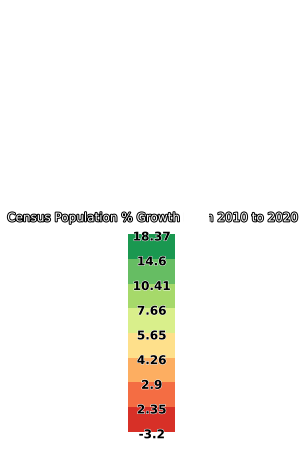

In [30]:
census_2010_2020_state_population_growth = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = 'census_2010_to_2020_chg', feature_text = 'State', 
    data_variable_text = 'Census Population % Growth From 2010 to 2020', 
    map_name = 'census_2010_2020_state_pop_growth', 
    variable_decimals = 2,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

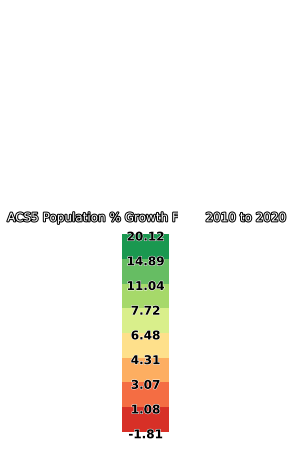

In [31]:
acs5_2010_2020_state_population_growth = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = 'acs5_2010_to_2020_chg', feature_text = 'State', 
    data_variable_text = 'ACS5 Population % Growth From 2010 to 2020', 
    map_name = 'acs5_2010_2020_state_pop_growth', 
    variable_decimals = 2,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

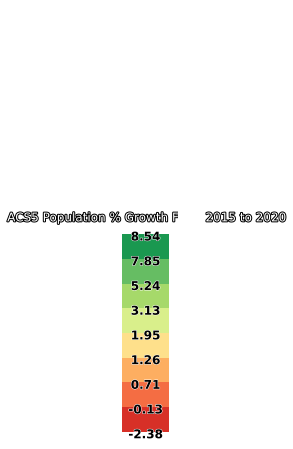

In [32]:
acs5_2015_2020_state_population_growth = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = 'acs5_2015_to_2020_chg', feature_text = 'State', 
    data_variable_text = 'ACS5 Population % Growth From 2015 to 2020', 
    map_name = 'acs5_2015_2020_state_pop_growth', 
    variable_decimals = 2,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

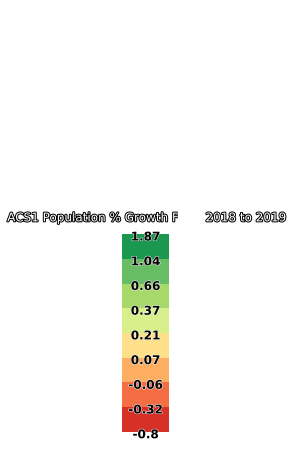

In [41]:
acs1_2018_2019_state_population_growth = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = 'acs1_2018_to_2019_chg', feature_text = 'State', 
    data_variable_text = 'ACS1 Population % Growth From 2018 to 2019', 
    map_name = 'acs1_2018_2019_state_pop_growth', 
    variable_decimals = 2,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

In [34]:
county_and_census_table.to_csv('county_and_census_table.csv')

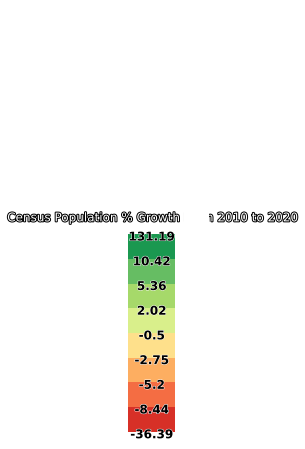

In [35]:
census_2010_2020_county_population_growth = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = 'census_2010_to_2020_chg', feature_text = 'County', 
    data_variable_text = 'Census Population % Growth From 2010 to 2020', 
    map_name = 'census_2010_2020_county_pop_growth', 
    variable_decimals = 2,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

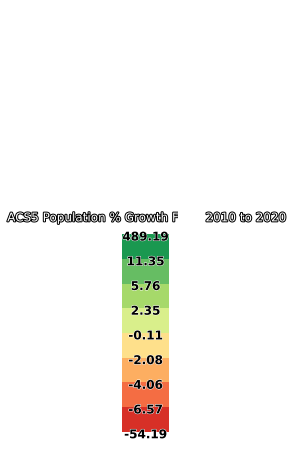

In [36]:
acs5_2010_2020_county_population_growth = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = 'acs5_2010_to_2020_chg', feature_text = 'County', 
    data_variable_text = 'ACS5 Population % Growth From 2010 to 2020', 
    map_name = 'acs5_2010_2020_county_pop_growth', 
    variable_decimals = 2,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

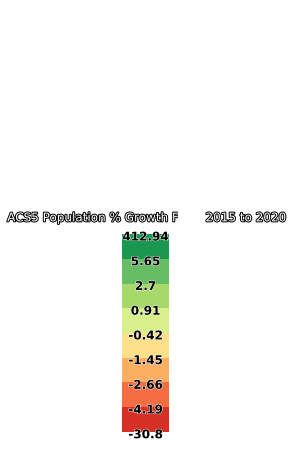

In [37]:
acs5_2015_2020_county_population_growth = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"), 
    shape_feature_name = 'NAME',
    data_variable = 'acs5_2015_to_2020_chg', feature_text = 'County', 
    data_variable_text = 'ACS5 Population % Growth From 2015 to 2020', 
    map_name = 'acs5_2015_2020_county_pop_growth', 
    variable_decimals = 2,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

For the zip code map, zip codes with a population of 0 in 2015 are removed, since otherwise infinite or NaN values would be returned (as dividing by 0 isn't possible). In addition, zip codes with missing coordinate polygons are also removed (via dropna(subset=['geometry']). 

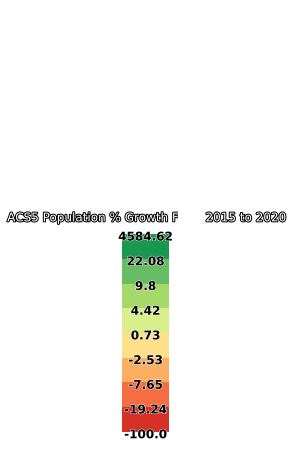

In [38]:
acs5_2015_2020_zip_population_growth = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table.query(
        'acs5_population_2015 > 0 & state != 72').dropna(
            subset=['geometry']), shape_feature_name = 'NAME',
    data_variable = 'acs5_2015_to_2020_chg', feature_text = 'zip', 
    data_variable_text = 'ACS5 Population % Growth From 2015 to 2020', 
    map_name = 'acs5_2015_2020_zip_pop_growth', 
    variable_decimals = 2,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Growth', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 100, vertical_legend = True, 
    generate_image = True)

And that's it! More maps can be created with the DataFrames provided than are shown here, so feel free to experiment with the datasets and to apply the functions in census_folium_viewer to your own data tables!

In [39]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),
"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),
"second(s))") 
# Only meaningful when the program is run nonstop from start to finish

Completed run at Fri Apr  1 18:33:59 2022 (local time)
Total run time: 723.82 second(s) (12.0 minute(s) and 3.82 second(s))
